#Introdução

Este notebook apresenta o processo de criação de uma rede neural LSTM para predição de fraudes em contas de água. Os dados utilizados já foram previamente tratados e analisados em nosso notebook de análise e preparação.

A Aegea, fundada em 2010, é uma das principais referências no setor privado de saneamento básico no Brasil. Com atuação em mais de 500 cidades em 15 estados, a empresa atende mais de 31 milhões de pessoas, promovendo saúde e qualidade de vida por meio da gestão de serviços essenciais, como abastecimento de água e tratamento de esgoto.

#Importação de Configurações

##Instalação das bibliotecas

In [157]:
!pip install keras
!pip install keras-tuner
!pip install ann_visualizer
!pip install graphviz
!pip install h5py
!pip install scikit-learn haversine
!pip install keras scikit-learn bayesian-optimization

##Importação das bibliotecas

In [158]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras_tuner import RandomSearch
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import datetime
from keras.utils import plot_model
import tensorflow as tf
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, log_loss
from bayes_opt import BayesianOptimization
from keras.models import Sequential
from google.colab import drive
from keras.layers import Dense

#Carregamento e visualização dos dados

##Carregando os dados

In [159]:
drive.mount('/content/drive')
file_path = '/content/drive/Shareddrives/M11_SI/final_base2.parquet'
df = pd.read_parquet(file_path)

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,MATRICULA_NaT,CATEGORIA_COMERCIAL_2019-01-01 00:00:00,CATEGORIA_COMERCIAL_2019-02-01 00:00:00,CATEGORIA_COMERCIAL_2019-03-01 00:00:00,CATEGORIA_COMERCIAL_2019-04-01 00:00:00,CATEGORIA_COMERCIAL_2019-05-01 00:00:00,CATEGORIA_COMERCIAL_2019-06-01 00:00:00,CATEGORIA_COMERCIAL_2019-07-01 00:00:00,CATEGORIA_COMERCIAL_2019-08-01 00:00:00,CATEGORIA_COMERCIAL_2019-09-01 00:00:00,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,FRAUDE
0,17000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.406525,0.0,0.274805,-0.235090,-0.456189,-0.201091,0.689645,1.712319,0.254239,0
1,17075331,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,0
2,17075333,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,0
3,17075335,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,1
4,17075336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,1


##Breve visualização dos dados tratados

In [160]:
#colunas e tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379575 entries, 0 to 379574
Columns: 828 entries, MATRICULA_NaT to FRAUDE
dtypes: float64(801), int64(3), object(24)
memory usage: 2.3+ GB


In [161]:
#Quantidade de linhas e colunas
df.shape

(379575, 828)

In [162]:
df.describe() #estatísticas descritivas das colunas numéricas

,MATRICULA_NaT,CATEGORIA_COMERCIAL_2019-01-01 00:00:00,CATEGORIA_COMERCIAL_2019-02-01 00:00:00,CATEGORIA_COMERCIAL_2019-03-01 00:00:00,CATEGORIA_COMERCIAL_2019-04-01 00:00:00,CATEGORIA_COMERCIAL_2019-05-01 00:00:00,CATEGORIA_COMERCIAL_2019-06-01 00:00:00,CATEGORIA_COMERCIAL_2019-07-01 00:00:00,CATEGORIA_COMERCIAL_2019-08-01 00:00:00,CATEGORIA_COMERCIAL_2019-09-01 00:00:00,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,FRAUDE
count,3.795750e+05,379575.000000,379575.000000,379575.000000,379575.000000,379575.000000,379575.000000,379575.000000,379575.000000,379575.000000,...,379554.000000,379554.000000,379554.000000,379554.000000,379554.000000,379554.000000,379554.000000,379554.000000,379554.000000,379575.000000
mean,1.764489e+07,0.075735,0.075716,0.075569,0.075484,0.075495,0.075432,0.075353,0.075139,0.075095,...,0.339136,0.067815,0.418885,0.504726,0.239797,0.242035,0.779648,0.201204,0.345470,0.324047
std,2.895757e+05,0.264574,0.264544,0.264307,0.264172,0.264189,0.264087,0.263960,0.263616,0.263544,...,1.030344,0.268031,1.240494,1.313272,0.908663,0.836946,1.498094,0.869290,1.014762,0.468018
min,1.700000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.509131,0.000000,-0.422257,-0.289046,-0.643034,-0.662401,-0.020646,-0.885798,-0.435542,0.000000
25%,1.735924e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.343662,0.000000,-0.320372,-0.284548,-0.400940,-0.379809,-0.020646,-0.418429,-0.328626,0.000000
50%,1.778456e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.788381e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.656338,0.000000,0.679628,0.715452,0.599060,0.620191,0.979354,0.581571,0.671374,1.000000
max,1.798557e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,9.926554,7.124459,13.588117,25.688940,14.845436,6.760050,18.437627,9.377607,14.029310,1.000000


In [163]:
df = df.select_dtypes(include=['int64', 'float64'])

### Tratamento basico

consideramos que o dataset estava 90% preparado para esta etapa, então vamos realizar alguns pequenos ajustes commo a remoção das colunas de fraude que que estão duplicadas e também ajustes de alguns valores infinitos ou nan

In [164]:
# Preencher valores NaN com 0
df.fillna(0, inplace=True)

# Substituir valores infinitos por 0
df.replace([np.inf, -np.inf], 0, inplace=True)

# Verifique se ainda há NaN ou infinitos após o tratamento
print("NaNs após o tratamento:", df.isnull().sum().sum())  # Deve ser 0
print("Infinitos após o tratamento:", np.isinf(df).sum().sum())  # Deve ser 0


NaNs após o tratamento: 0
Infinitos após o tratamento: 0


In [165]:
# Nome da coluna que você quer manter
coluna_a_manter = 'FRAUDE'

# Filtrando o DataFrame para remover todas as outras colunas que contêm 'FRAUDE', exceto a que você quer manter
colunas_fraude = df.filter(regex='FRAUDE').columns
colunas_a_remover = [col for col in colunas_fraude if col != coluna_a_manter]

# Removendo as colunas indesejadas
df = df.drop(columns=colunas_a_remover)

In [166]:
df

,MATRICULA_NaT,CATEGORIA_COMERCIAL_2019-01-01 00:00:00,CATEGORIA_COMERCIAL_2019-02-01 00:00:00,CATEGORIA_COMERCIAL_2019-03-01 00:00:00,CATEGORIA_COMERCIAL_2019-04-01 00:00:00,CATEGORIA_COMERCIAL_2019-05-01 00:00:00,CATEGORIA_COMERCIAL_2019-06-01 00:00:00,CATEGORIA_COMERCIAL_2019-07-01 00:00:00,CATEGORIA_COMERCIAL_2019-08-01 00:00:00,CATEGORIA_COMERCIAL_2019-09-01 00:00:00,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,FRAUDE
0,17000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.406525,0.0,0.274805,-0.235090,-0.456189,-0.201091,0.689645,1.712319,0.254239,0
1,17075331,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,0
2,17075333,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,0
3,17075335,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,1
4,17075336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379570,17985460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.330088,0.0,0.343256,0.144272,1.396051,0.060913,0.545153,0.221605,-0.225350,0
379571,17985461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.330088,0.0,0.343256,0.144272,1.396051,0.060913,0.545153,0.221605,-0.225350,0
379572,17985468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.216670,0.0,1.454838,1.422725,1.277255,0.802903,1.643950,0.298214,0.626644,0
379573,17985570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.494471,0.0,0.873156,2.096671,0.808530,0.398298,2.202055,0.899929,0.576243,0


##Séries temporais

In [167]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Selecione as colunas de séries temporais e os rótulos
temporal_columns = [col for col in df.columns if 'CATEGORIA_COMERCIAL' in col]
features = df[temporal_columns].values
labels = df['FRAUDE'].values

In [168]:
# Definir o número de timestamps e as features por entrada (n_samples, timestamps, n_features)
n_timestamps = len(temporal_columns)
n_features = 1

###Reshape dos dados

In [169]:
# Reshape dos dados para formato (n amostras, timestamps, features)
X = features.reshape(features.shape[0], n_timestamps, n_features)


In [183]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Divisão dos dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Obter a forma original dos dados 3D
n_samples, timesteps, features = X_train.shape

# Redimensionar os dados de 3D para 2D (necessário para o undersampling)
X_train_reshaped = X_train.reshape((n_samples, timesteps * features))

# Aplicar o undersampling no conjunto de treino
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_reshaped, y_train)

# Redimensionar de volta para 3D
X_resampled = X_resampled.reshape((X_resampled.shape[0], timesteps, features))

# Agora, X_resampled e y_resampled podem ser usados para treinar o LSTM


In [171]:
# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(n_timestamps, n_features)))
model.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [181]:
# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [173]:
df

,MATRICULA_NaT,CATEGORIA_COMERCIAL_2019-01-01 00:00:00,CATEGORIA_COMERCIAL_2019-02-01 00:00:00,CATEGORIA_COMERCIAL_2019-03-01 00:00:00,CATEGORIA_COMERCIAL_2019-04-01 00:00:00,CATEGORIA_COMERCIAL_2019-05-01 00:00:00,CATEGORIA_COMERCIAL_2019-06-01 00:00:00,CATEGORIA_COMERCIAL_2019-07-01 00:00:00,CATEGORIA_COMERCIAL_2019-08-01 00:00:00,CATEGORIA_COMERCIAL_2019-09-01 00:00:00,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,FRAUDE
0,17000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.406525,0.0,0.274805,-0.235090,-0.456189,-0.201091,0.689645,1.712319,0.254239,0
1,17075331,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,0
2,17075333,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,0
3,17075335,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,1
4,17075336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.308187,0.0,0.693426,-0.289046,0.682932,0.399495,0.758024,0.582130,0.434080,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379570,17985460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.330088,0.0,0.343256,0.144272,1.396051,0.060913,0.545153,0.221605,-0.225350,0
379571,17985461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.330088,0.0,0.343256,0.144272,1.396051,0.060913,0.545153,0.221605,-0.225350,0
379572,17985468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.216670,0.0,1.454838,1.422725,1.277255,0.802903,1.643950,0.298214,0.626644,0
379573,17985570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.494471,0.0,0.873156,2.096671,0.808530,0.398298,2.202055,0.899929,0.576243,0


In [185]:
# Treinar o modelo
model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
6141/6141 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.5018 - loss: 0.6958 - val_accuracy: 0.3583 - val_loss: 0.6921
Epoch 2/10
6141/6141 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.5015 - loss: 0.6931 - val_accuracy: 0.6740 - val_loss: 0.6841
Epoch 3/10
6141/6141 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.5045 - loss: 0.6931 - val_accuracy: 0.3583 - val_loss: 0.6953
Epoch 4/10
6141/6141 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.5032 - loss: 0.6930 - val_accuracy: 0.3583 - val_loss: 0.6951
Epoch 5/10
6141/6141 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.5037 - loss: 0.6930 - val_accuracy: 0.3584 - val_loss: 0.6918
Epoch 6/10
6141/6141 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.5024 - loss: 0.6930 - val_accuracy: 0.3583 - val_loss: 0.6928
Epoch 7/10
6141/6141 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.5071 - loss: 0.6929 - val_accuracy: 0.3583 - val_loss: 0.6945
Epoch 8/10
6141/6141 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.5064 - loss: 0

#Avaliação do modelo

In [186]:
# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)

2373/2373 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3577 - loss: 0.6932


In [187]:
from sklearn.metrics import precision_score, recall_score, classification_report

# Fazer previsões no conjunto de teste
y_pred_probs = model.predict(X_test)

# Converter probabilidades para rótulos binários (0 ou 1)
# O threshold típico é 0.5, mas pode ser ajustado conforme necessário
y_pred = (y_pred_probs > 0.5).astype(int)

# Calcular precision e recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Também pode exibir um relatório completo com outras métricas como F1-score
print(classification_report(y_test, y_pred))

2373/2373 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Precision: 0.3285785821589527
Recall: 0.9278817017494243
              precision    recall  f1-score   support

           0       0.70      0.08      0.15     51164
           1       0.33      0.93      0.49     24751

    accuracy                           0.36     75915
   macro avg       0.52      0.51      0.32     75915
weighted avg       0.58      0.36      0.26     75915



O modelo apresenta um desempenho sólido na classe "0", onde a precisão de 0,70 indica que ele acerta a maioria das previsões de clientes que não estão cometendo fraudes. No entanto, enfrenta sérios problemas na classe "1". Apesar de identificar 93% das fraudes, a precisão de apenas 0,33 sugere que muitas das sinalizações feitas como fraude são, na verdade, incorretas, resultando em falsos positivos. Isso gera um desperdício de recursos, pois cada caso sinalizado requer uma avaliação humana. Portanto, enquanto o modelo é eficaz em identificar clientes não fraudulentos, a necessidade de melhorar a detecção e a precisão nas previsões de fraudes é crucial para reduzir custos e melhorar a eficiência operacional.

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Fazer previsões no conjunto de teste
y_pred_probs = model.predict(X_test)

# Converter probabilidades para rótulos binários (0 ou 1)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calcular precision e recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

2373/2373 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Precision: 0.3285785821589527
Recall: 0.9278817017494243


              precision    recall  f1-score   support

           0       0.70      0.08      0.15     51164
           1       0.33      0.93      0.49     24751

    accuracy                           0.36     75915
   macro avg       0.52      0.51      0.32     75915
weighted avg       0.58      0.36      0.26     75915



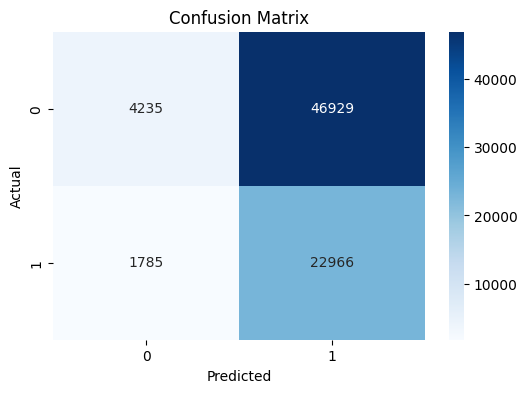

In [189]:
# Exibir o relatório completo com outras métricas como F1-score
print(classification_report(y_test, y_pred))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [192]:
print(conf_matrix)

[[ 4235 46929]
 [ 1785 22966]]


A matriz de confusão revela que o modelo é eficaz em identificar clientes não fraudulentos, com 4.235 acertos (verdadeiros negativos), mas enfrenta sérios desafios na detecção de fraudes. Apesar de identificar corretamente 22.966 fraudes (verdadeiros positivos), o alto número de 46.929 falsos positivos indica que muitos clientes legítimos estão sendo rotulados incorretamente como fraudulentos, resultando em desperdício de recursos em investigações desnecessárias.

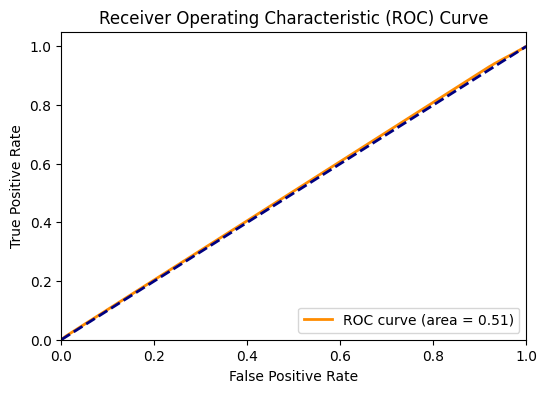

In [190]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#Conclusão


A análise dos resultados do modelo LSTM indica um desempenho insatisfatório, especialmente nas métricas de precisão e recall para a classe de fraudes. Em comparação, os resultados do modelo FeedForward foram melhores, sugerindo que, apesar de ser comum utilizar LSTMs para dados temporais, neste caso específico, o modelo FeedForward pode ser mais eficaz. Essa escolha pode ser particularmente relevante, considerando que a identificação de fraudes não depende necessariamente de sequências temporais, mas sim de características específicas dos dados. Portanto, pode ser vantajoso explorar a implementação do modelo FeedForward, dado seu desempenho superior, enquanto se continua a investigar formas de otimizar o modelo LSTM para futuras análises. Essa abordagem pode resultar em uma detecção de fraudes mais precisa e em uma alocação de recursos mais eficiente.